## Imports

In [ ]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from photutils.aperture import ApertureStats, CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture, EllipticalAnnulus
from photutils import Background2D, MedianBackground
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import os
import glob
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

/var/folders/l3/kynmmffn6mb9tjg_c1n4qtd80000gn/T/ipykernel_36002/541359783.py:4: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground
/var/folders/l3/kynmmffn6mb9tjg_c1n4qtd80000gn/T/ipykernel_36002/541359783.py:4: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground


## Definitions

#### This is long but it is where all the juicy parts are (photometry, error calculation, conversion to magnitude, etc)
#### User should only need to change the star list at this step to perform_phot to run properly
#### At beginning of definitions, define the star list to make sure it always falls back to it
Each time you come up with a new star list I suggest hardcoding it into the defaults so you know it will always fall back to it.

In [ ]:
star_list_pix = [(2495.9894,2254.0481), (1637.4738,1789.4859), (2834.608,822.51794), (1087.7509,1333.0649),(2229.0798,548.40375)]

aperture_radius = 8  # Radius of the aperture
annulus_inner_radius = 22  # Inner radius of the annulus
annulus_outer_radius = 30  # Outer radius of the annulus

a = 2 * aperture_radius
b = 6 * aperture_radius

gain = None # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
rdnoise = 2.8 # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning


'''The above parameters need to be set for the specific data set
The star_list_pix is the list of stars in pixel coordinates should be the only thing 
that needs to be changed regularly
The aperture_radius, annulus_inner_radius and annulus_outer_radius, a and b are set to default values
but can be changed if needed
The gain and rdnoise are set to correct values (MAY 2025 RLMT) but can be changed if needed
GAIN will read from the header if set to None, this is currently set to use 4*egain due to binning
'''



'''
Perform relative photometry on a set of images
Designed to all be in the same filter with same aperture settings
Variable FWHM photometry in different defn (coming soon)
By defaul the code will save to a csv file and plot results, this can be turned off with flags
'''

def perform_phot(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        display_apertures = False, # display the apertures and annuli on the reference image
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        save_file = True, # save the results to a file
        plot_file = True, # plot the results
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
        ):
    '''
    Function to combine filter results into single relative light curve
    Has section that can be commented in to highlight VLA overlap
    '''

    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: g')
        filt = 'g'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return

    # Find all FITS files in the directory
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return

    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)

    # Get read noise and gain
    rdnoise = rdnoise # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning 
    # to get to propagate through correctly need to put into electrons 
    # at gain 100 gain is 0.25 e/AUD quoted readnoise is 1.5 e/pix
    # quoted RN/gain is 6 ish counts.
    if gain is None:
        egain = header['EGAIN']
        gain = 4*egain
    else:
        gain = gain
    

    # Get the WCS information from the header    
    wcs = WCS(header)

    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg
    print('Target RA:', ra)
    print('Target Dec:', dec)
    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')            

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid
            
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            # Subtract the pedestal from the background for the error calculation
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude (not used here but useful for reference)
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Optionally, display the image with the apertures and annuli (set flag to True)
        # This is useful for checking the positions of the stars are correct
        if display_apertures:
            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True
    )

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    if save_file:
        results_df.to_csv(file_dir + 'Results_' + filt + '.csv', index=False)

    if plot_file:
        #Plot the relative flux
        #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
        plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
        plt.xlabel('Julian Date')
        plt.ylabel('Relative Flux')
        plt.show()

    # Return the results DataFrame
    return results_df


def make_light_curve(file_dir, filters=None, title=None, comp_stars=False):
    
    '''
    Function to calculate calibrated apparent magnitudes using the scale factor and ZP from the header
    Writes out results to a csv file with _Cal appended to the file name
    '''
    
    # Change to the directory containing the images
    os.chdir(file_dir)
    print('Current working directory:', os.getcwd())
    # Check if the directory exists
    if not os.path.isdir(file_dir):
        print('Directory does not exist. Exiting.')
        return
    
    # If filters are not provided, set it to ['g', 'r', 'i']
    if filters is None:
        print('No filters provided. Using default filters: g, r, i')
        filters = ['g', 'r', 'i']
    else:
        print('Using filters:', filters)

    # Check if g is in the filters list
    try:
        lc_g = pd.read_csv(file_dir + 'Results_g.csv')
        lc_g = lc_g.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_g['Julian_Date'], lc_g['norm_target_rel_flux'], yerr=lc_g['norm_target_rel_flux_error'], fmt='o', label='g', color='green')
        plt.plot(lc_g['Julian_Date'], lc_g['norm_target_rel_flux'], color='green')
    except FileNotFoundError:
        print('No g filter data found. Skipping g filter.')
    try:
        lc_r = pd.read_csv(file_dir + 'Results_r.csv')
        lc_r = lc_r.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_r['Julian_Date'], lc_r['norm_target_rel_flux'], yerr=lc_r['norm_target_rel_flux_error'], fmt='o', label='r', color='red')
        plt.plot(lc_r['Julian_Date'], lc_r['norm_target_rel_flux'], color='red')
    except FileNotFoundError:
        print('No r filter data found. Skipping r filter.')
    try:
        lc_i = pd.read_csv(file_dir + 'Results_i.csv')
        lc_i = lc_i.sort_values(by=['Julian_Date'])
        plt.errorbar(lc_i['Julian_Date'], lc_i['norm_target_rel_flux'], yerr=lc_i['norm_target_rel_flux_error'], fmt='o', label='i', color='purple')
        plt.plot(lc_i['Julian_Date'], lc_i['norm_target_rel_flux'], color='purple')
    except FileNotFoundError:
        print('No i filter data found. Skipping i filter.')

    # If comp_stars is True, plot the comparison stars
    if comp_stars:
        try:
            lc_g = pd.read_csv(file_dir + 'Results_g.csv')
            lc_g = lc_g.sort_values(by=['Julian_Date'])
            plt.scatter(lc_g['Julian_Date'], lc_g['star_1_relflux']/np.mean(lc_g['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_g['Julian_Date'], lc_g['star_2_relflux']/np.mean(lc_g['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_g['Julian_Date'], lc_g['star_3_relflux']/np.mean(lc_g['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_g['Julian_Date'], lc_g['star_4_relflux']/np.mean(lc_g['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_g['Julian_Date'], lc_g['star_5_relflux']/np.mean(lc_g['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No g filter data found. Skipping g filter.')
        try:
            lc_r = pd.read_csv(file_dir + 'Results_r.csv')
            lc_r = lc_r.sort_values(by=['Julian_Date'])
            plt.scatter(lc_r['Julian_Date'], lc_r['star_1_relflux']/np.mean(lc_r['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_r['Julian_Date'], lc_r['star_2_relflux']/np.mean(lc_r['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_r['Julian_Date'], lc_r['star_3_relflux']/np.mean(lc_r['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_r['Julian_Date'], lc_r['star_4_relflux']/np.mean(lc_r['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_r['Julian_Date'], lc_r['star_5_relflux']/np.mean(lc_r['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No r filter data found. Skipping r filter.')
        try:
            lc_i = pd.read_csv(file_dir + 'Results_i.csv')
            lc_i = lc_i.sort_values(by=['Julian_Date'])
            plt.scatter(lc_i['Julian_Date'], lc_i['star_1_relflux']/np.mean(lc_i['star_1_relflux']), alpha=0.2, color='C0')
            plt.scatter(lc_i['Julian_Date'], lc_i['star_2_relflux']/np.mean(lc_i['star_2_relflux']), alpha=0.2, color='C1')
            plt.scatter(lc_i['Julian_Date'], lc_i['star_3_relflux']/np.mean(lc_i['star_3_relflux']), alpha=0.2, color='C2')
            plt.scatter(lc_i['Julian_Date'], lc_i['star_4_relflux']/np.mean(lc_i['star_4_relflux']), alpha=0.2, color='C3')
            plt.scatter(lc_i['Julian_Date'], lc_i['star_5_relflux']/np.mean(lc_i['star_5_relflux']), alpha=0.2, color='C4')
        except FileNotFoundError:
            print('No i filter data found. Skipping i filter.')
 
    # Give labels to the axes and a title
    if title is None:
        plt.title('Light Curve')
    else:
        plt.title(title)
    
    ### This is where you can add in highlighting of VLA overlap:
    # # Convert the utc to JD
    # t_start = Time('2025-05-02T06:39:00', scale='utc')
    # # Get the Julian Date
    # jd_start = t_start.jd

    # t_end = Time('2025-05-02T09:39:00', scale='utc')
    # # Get the Julian Date
    # jd_end = t_end.jd

    # plt.axvline(x=jd_start, color='black', linestyle='--')
    # plt.axvline(x=jd_end, color='black', linestyle='--')
    # plt.fill_betweenx([0.5, 1.5], jd_start, jd_end, color='blue', alpha=0.2)

    plt.xlabel('Julian Date')
    plt.ylabel('Relative Flux')
    plt.legend()
    plt.show()


def find_mags(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture (needs to be the same as in perform_phot)
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus (needs to be the same as in perform_phot)
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus (needs to be the same as in perform_phot)
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        display_apertures = False, # display the apertures and annuli on the reference image
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain, # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
        ):
    '''
    Finds the scale factor to correct to "infinite" apertures 
    and provides warnings if the scale factor is too small or large
    '''
    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: g')
        filt = 'g'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return

    # Find all FITS files in the directory
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return

    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)

    # Get read noise and gain
    rdnoise = rdnoise
    if gain is None:
        egain = header['EGAIN']
        gain = 4*egain
    else:
        gain = gain

    # Get the WCS information from the header    
    wcs = WCS(header)

    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg

    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')            

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        skip_file = False


        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid
            
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            # Subtract the pedestal from the background for the error calculation
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                skip_file = True
                break

            # Error calculation (Poisson noise + background noise + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude 
            header = fits.getheader(image_file)
            try:
                scale = header['SCALE']
            except KeyError:
                # If the scale is not found in the header, set it to 1
                scale = 1.0
                print('Scale not found in header, using default value of 1.0')
            try:
                zpmag = header['ZPMAG']
            except KeyError:
                # If the zero point magnitude is not found in the header, skip this file
                print('Skipping', {image_file}, ': Zero point magnitude not found in header')
                skip_file = True
                break
            try:
                zpmag_err = header['Z_ERR']
            except KeyError:
                # If the zero point magnitude error is not found in the header, set it to 0
                print('Skipping', {image_file}, ': Zero point magnitude not found in header')
                skip_file = True
                break 
            source_mag = -2.5 * np.log10(scale*source_sum / exptime)
            source_mag_cor = source_mag + zpmag
            source_mag_err = 1.0857 * error / source_sum
            source_mag_cor_err = np.sqrt(source_mag_err**2 + zpmag_err**2)

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum
            file_results[f'star_{i}_mag'] = source_mag_cor
            file_results[f'star_{i}_mag_error'] = source_mag_cor_err
        if skip_file:
            continue
        else:
            # Append the results for this file to the list of all results
            all_results.append(file_results)

        if display_apertures:
            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True
    )

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_Cal_' + filt + '.csv', index=False)


def calc_ap_ratio(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture (needs to be the same as in perform_phot)
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus (needs to be the same as in perform_phot)
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus (needs to be the same as in perform_phot)
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        larger_ap = 18, # Larger aperture radius
        mean=False,
        median=False,
        ):
    # Intialize the results dataframe
    results_df = pd.DataFrame()

    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt,
                 aperture_radius=aperture_radius,
                 annulus_inner_radius=annulus_inner_radius,
                 annulus_outer_radius=annulus_outer_radius,
                 star_list=star_list,
                 target_name=target_name,
                 save_file=False,
                 plot_file=False
                 )
    #initiate a new dataframe
    scale_df = pd.DataFrame()
    # Set all the results to new colums
    for i in range(1, 6):
        scale_df[f'star_{i}_flux_original'] = results_df[f'star_{i}_flux']
        scale_df[f'star_{i}_error_original'] = results_df[f'star_{i}_error']
    
    results_df = pd.DataFrame()

    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt,
                 aperture_radius=larger_ap,
                 annulus_inner_radius=annulus_inner_radius,
                 annulus_outer_radius=annulus_outer_radius,
                 star_list=star_list,
                 target_name=target_name,
                 save_file=False,
                 plot_file=False
                 )
    
    for i in range(1, 6):
        scale_df[f'file'] = results_df['file']
        scale_df[f'star_{i}_flux_large'] = results_df[f'star_{i}_flux']
        scale_df[f'star_{i}_error_large'] = results_df[f'star_{i}_error']
    
    # Calculate the ratio of the fluxes
    for i in range(1, 6):
        scale_df[f'file'] = results_df['file']
        scale_df[f'star_{i}_flux_ratio'] = scale_df[f'star_{i}_flux_large']/scale_df[f'star_{i}_flux_original']
        scale_df[f'star_{i}_error_ratio'] = np.sqrt((scale_df[f'star_{i}_error_original']/scale_df[f'star_{i}_flux_original'])**2 + (scale_df[f'star_{i}_error_large']/scale_df[f'star_{i}_flux_large'])**2)
    
    ratio_columns = [f'star_{i}_flux_ratio' for i in range(1, 6)]
    # Calculate the mean and median of the ratios
    if mean:
        scale_df['mean_ratio'] = scale_df[ratio_columns].mean(axis=1)
        scale_df['mean_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['mean_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing mean scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['mean_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')
    if median:
        scale_df['median_ratio'] = scale_df[ratio_columns].median(axis=1)
        scale_df['median_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['median_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing median scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['median_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')
    else:
        scale_df['median_ratio'] = scale_df[ratio_columns].median(axis=1)
        scale_df['median_error'] = scale_df[ratio_columns].std(axis=1)
        for fn, scale in zip(scale_df['file'], scale_df['median_ratio']):
            fits.setval(fn,
            ext=0,
            keyword='SCALE',
            value=scale,
            comment='Photometric scale factor')
            #print('Writing median scale factor to header:', fn, scale)
            if scale < 1:
                print('Scale factor is less than 1, check the image:', fn)
            if scale > 1.5:
                print('Scale factor is greater than 1.5, check the image:', fn)
        for fn, scale_err in zip(scale_df['file'], scale_df['median_error']):
            fits.setval(fn,
            ext=0,
            keyword='SC_ERR',
            value=scale_err,
            comment='Scale error (std of ratios)')


def absoulte_light_curve(file_dir, filters=['g', 'r', 'i'], title=None):
    
    '''
    Plots the light curve using the apparent magnitudes
    '''
    
    if title is None:
        title = 'Absolute Light Curve'
    # Change to the directory containing the images
    os.chdir(file_dir)
    print('Current working directory:', os.getcwd())
    # Check if the directory exists
    if not os.path.isdir(file_dir):
        print('Directory does not exist. Exiting.')
        return
    
    # If filters are not provided, set it to ['g', 'r', 'i']
    if filters is None:
        print('No filters provided. Using default filters: g, r, i')
        filters = ['g', 'r', 'i']
    else:
        print('Using filters:', filters)
    
    # if 'g' in the filters list
    if 'g' in filters:
        results_g = pd.read_csv(file_dir + '/Results_Cal_g.csv')
        new_results_g_df = pd.DataFrame({
        'file': results_g['file'],
        'Julian_Date': results_g['Julian_Date'],
        'target_mag_g': results_g['target_mag'],
        'target_mag_err_g': results_g['target_mag_error'],})
        results_g = new_results_g_df.sort_values('Julian_Date')
        plt.errorbar(results_g['Julian_Date'], results_g['target_mag_g'], yerr=results_g['target_mag_err_g'], fmt='o-', label='g', color="green", markersize=6)
    # if 'r' in the filters list
    if 'r' in filters:
        results_r = pd.read_csv(file_dir + '/Results_Cal_r.csv')
        new_results_r_df = pd.DataFrame({
        'file': results_r['file'],
        'Julian_Date': results_r['Julian_Date'],
        'target_mag_r': results_r['target_mag'],
        'target_mag_err_r': results_r['target_mag_error'],})
        results_r = new_results_r_df.sort_values('Julian_Date')
        plt.errorbar(results_r['Julian_Date'], results_r['target_mag_r'], yerr=results_r['target_mag_err_r'], fmt='o-', label='r', color="red", markersize=6)
    # if 'i' in the filters list
    if 'i' in filters:
        results_i = pd.read_csv(file_dir + '/Results_Cal_i.csv')
        new_results_i_df = pd.DataFrame({
        'file': results_i['file'],
        'Julian_Date': results_i['Julian_Date'],
        'target_mag_i': results_i['target_mag'],
        'target_mag_err_i': results_i['target_mag_error'],
        'target_i_zp': results_i['zero_point'],})
        results_i = new_results_i_df.sort_values('Julian_Date')
        plt.errorbar(results_i['Julian_Date'], results_i['target_mag_i'], yerr=results_i['target_mag_err_i'], fmt='o-', label='i', color="purple", markersize=6)

    plt.xlabel('Julian Date')
    plt.ylabel('Apparent Magnitude')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()


def add_radio(path = None, date = None):
    
    '''
    Optional: to plot the data with the radio data, all will be normalized to scale from 0 to 1
    Needs to be teested
    '''
    
    # Check if the directory exists
    if path is None:
        print('No directory provided. Using current working directory.')
        path = os.getcwd()
    else:
        print('Using directory:', path)
        # Change to the directory containing the images
        os.chdir(path)
        # Check if the directory exists
        if not os.path.isdir(path):
            print('Directory does not exist. Exiting.')
            return
    # Check if the date is provided in format year-month-day
    if date is None:
        print('No date provided. Using current date.')
        date = datetime.datetime.now().strftime("%Y-%m-%d")
    else:
        print('Using date:', date)
    # Check if the date is in the correct format
    try:
        datetime.datetime.strptime(date, "%Y-%m-%d")
    except ValueError:
        print('Date is not in the correct format. Exiting.')
        return
    # Add T to end of the date
    date = date + 'T'
    # Read the radio data
    radio_data = pd.read_csv(path + '/radio.csv')
    # Read in the first column as time and the second column as flux
    time = radio_data['time'].astype(str)
    flux = radio_data['flux'].astype(float)
    flux_err = radio_data['flux_err'].astype(float)
    time_iso = date + time  # Vectorized string concatenation
    time_iso_list = time_iso.tolist() 
    t = Time(time_iso_list, format='isot', scale='utc') # Convert all at once
    jd = t.jd
    min_flux = np.min(flux)
    max_flux = np.max(flux)
    norm_x_flux = (flux-min_flux)/(max_flux-min_flux)
    norm_x_flux_err = flux_err/(np.max(flux)-np.min(flux))

    x_results = pd.DataFrame({
    'Julian_Date': jd,
    'x_flux': flux,
    'x_flux_err': flux_err,
    'norm_x_flux': norm_x_flux,
    'norm_x_flux_err': norm_x_flux_err
    })

    return x_results


def perform_e_phot(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture (needs to be the same as in perform_phot)
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        save_file = True,
        plot_file = True,
        display_apertures = False, # display the apertures and annuli on the reference image
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain, # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        a = 2*aperture_radius, # Major axis of the elliptical aperture
        b = aperture_radius*6, # Minor axis of the elliptical aperture
        theta = 0, # Angle of the elliptical aperture
        ):
    
    '''
    Function to background subtract images and use elliptical apertures to do photometry 
    (probably not the best method)
    '''
    
    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: g')
        filt = 'g'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return
    # Find all FITS files in the directory  
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return
    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)
    # Get read noise and gain
    rdnoise = rdnoise
    if gain is None:
        egain = header['EGAIN']
        gain = 4*egain
    else:
        gain = gain
    # Get the WCS information from the header
    wcs = WCS(header)
    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    print('Target Name:', target_name)
    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg
    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')
    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}

        #Make a 2D background model of the image
        bkg_estimator = MedianBackground()
        bkg = Background2D(data, (30, 30), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3), bkg_estimator=bkg_estimator)
        new_data = data - bkg.background

        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap =EllipticalAperture((x, y), a=a, b=b, theta = theta)
            #an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            #bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(new_data, ap)

            # Recentroid the aperture
            x, y = ap_stats.centroid #not sure this will work with elliptical apertures
            
        
            aperture = EllipticalAperture((x, y), a= a, b=b, theta=theta)
            #annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = ApertureStats(new_data, aperture)
            #bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            # bkg_mean = bkgstats.mean
            # bkg_sum = bkg_mean * aperture.area
            
            # # Subtract the pedestal from the background for the error calculation
            # bkg_mean_nopedestal = bkg_mean-1000
            # bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table.sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise (not currently included) + read noise)
            error = np.sqrt(source_sum + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude (not used here but useful for reference)
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            #file_results[f'star_{i}_background'] = bkg_sum

        if display_apertures:
            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = EllipticalAperture((x, y), a=a, b=b, theta=theta)
                #annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                #annulus_aperture.plot(color='red', lw=1.5)
            plt.show()
        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True)

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    if save_file:
        results_df.to_csv(file_dir + 'Results_' + filt + '.csv', index=False)

    if plot_file:
        #Plot the relative flux
        #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
        plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
        plt.xlabel('Julian Date')
        plt.ylabel('Relative Flux')
        plt.show()

    # Return the results DataFrame
    return results_df


def perform_e_ap_phot(file_dir=None, ref_image=None, filt=None,
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        save_file = True,
        plot_file = True,
        display_apertures = False, # display the apertures and annuli on the reference image
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain, # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        a = a, # Major axis of the elliptical aperture
        b = b, # Minor axis of the elliptical aperture
        theta = 0, # Angle of the elliptical aperture
        a_in = a + 5,
        a_out = a + 10,
        b_in = b + 5,
        b_out = b + 10
        ):
    
    '''
    Function to perform elliptical aperture photometry on the images (for windy or bouncy images)
    '''

    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: g')
        filt = 'g'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return
    # Find all FITS files in the directory  
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return
    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)
    # Get read noise and gain
    rdnoise = rdnoise
    if gain is None:
        egain = header['EGAIN']
        gain = 4*egain
    else:
        gain = gain
    # Get the WCS information from the header
    wcs = WCS(header)
    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    print('Target Name:', target_name)
    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg
    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')
    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}

        #Make a 2D background model of the image
        # bkg_estimator = MedianBackground()
        # bkg = Background2D(data, (30, 30), filter_size=(3, 3), sigma_clip=SigmaClip(sigma=3), bkg_estimator=bkg_estimator)
        # new_data = data - bkg.background

        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)

        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = EllipticalAperture((x, y), a=a, b=b, theta = theta)
            an = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = theta)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid #not sure this will work with elliptical apertures
            
        
            aperture = EllipticalAperture((x, y), a= a, b=b, theta=theta)
            annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = theta)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            # Subtract the pedestal from the background for the error calculation
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise (not currently included) + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + (aperture.area/annulus_aperture.area)*bkg_sum_nopedestal*gain+aperture.area*rdnoise**2)

            # Optionally turn into a magnitude (not used here but useful for reference)
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            #file_results[f'star_{i}_background'] = bkg_sum

        if display_apertures:
            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = EllipticalAperture((x, y), a=a, b=b, theta=theta)
                annulus_aperture = EllipticalAnnulus((x, y), a_in=a_in, a_out=a_out, b_in=b_in, b_out=b_out, theta = theta)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()
        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True)

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux'] + results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    if save_file:
        results_df.to_csv(file_dir + 'Results_' + filt + '.csv', index=False)

    if plot_file:
        #Plot the relative flux
        #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
        plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
        plt.xlabel('Julian Date')
        plt.ylabel('Relative Flux')
        plt.show()

    # Return the results DataFrame
    return results_df


    """
    Computes the FWHM of stars using a pixel-by-pixel brute force approach.
    
    Parameters:
    - positions: List of (x, y) coordinates of stars to analyze.
    - size: Size of the search box around each star.
    
    Returns:
    - fwhm_list: List of computed FWHM values.
    - fwhm_median: Median FWHM of all stars analyzed.
    """


def find_fwhm(image, positions, size=30):
    """
    Computes the FWHM of stars using a pixel-by-pixel brute force approach.
    
    Parameters:
    - positions: List of (x, y) coordinates of stars to analyze.
    - size: Size of the search box around each star.
    
    Returns:
    - fwhm_list: List of computed FWHM values.
    - fwhm_median: Median FWHM of all stars analyzed.
    """

    fwhm_list = []

    # Load the FITS data
    image = fits.getdata(image)

    # Estimate background
    bkg_estimator = MedianBackground()
    sigma_clip = SigmaClip(sigma=3.0)
    bkg = Background2D(image, (100, 100), filter_size=(5, 5),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

    # Subtract background
    data = image.astype(float)
    data -= bkg.background

    for x, y in positions:
        x, y = int(x), int(y)

        # Ensure cutout is within bounds
        if (x - size < 0 or x + size >= data.shape[1] or
                y - size < 0 or y + size >= data.shape[0]):
            continue

        # Extract the cutout region centered on (x, y)
        cutout = data[y - size:y + size + 1, x - size:x + size + 1]  

        # Use the provided (x, y) center instead of the brightest pixel
        peak_intensity = cutout.max()
        if peak_intensity <= 0:
            continue  # Skip if intensity is invalid

        half_max = 0.5 * peak_intensity  # Compute half-max threshold
        # --- Search outward in X and Y directions ---
        fwhm_x = 0
        fwhm_y = 0

        # X direction (horizontal)
        y_indices, x_indices = np.where(cutout > half_max)

        if len(x_indices) > 0:
            fwhm_x = np.max(x_indices) - np.min(x_indices)
            fwhm_x += 1  # Add 1 to convert from indices to pixels
        if fwhm_x == 0:
            fwhm_x = 20
        if len(y_indices) > 0:
            fwhm_y = np.max(y_indices) - np.min(y_indices)
            fwhm_y += 1
        if fwhm_y == 0:
            fwhm_y = 20
        # Average the FWHM in both directions
        fwhm = (fwhm_x + fwhm_y) / 2
        fwhm_list.append(fwhm)

    return fwhm_list


def perform_var_fwhm_phot(file_dir=None, ref_image=None, filt=None,
        aperture_radius = aperture_radius,  # Radius of the aperture
        annulus_inner_radius = annulus_inner_radius,  # Inner radius of the annulus
        annulus_outer_radius = annulus_outer_radius,  # Outer radius of the annulus
        star_list = star_list_pix, # star list in pixel coords for reference imaage
        ref_star_coords = None, # star list in ra/dec coords for reference image
        save_ref_star_coords = False, # save the star list in ra/dec coords for reference image
        display_apertures = False, # display the apertures and annuli on the reference image
        target_name = None, # Target name for WCS, if none provided, it will be taken from the header
        save_file = True, # save the results to a file
        plot_file = True, # plot the results
        rdnoise = rdnoise, # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning
        gain = gain # If "None", set dynamically from the header (currently set to use 4*egain due to binning)
        ):
    '''
    Function to perform variable FWHM photometry on images
    for images with focus issues 
    may also work for windy or bouncy images
    '''
    # Check that the directory exists
    if file_dir is None:
        print('No directory provided. Using current working directory.')
        file_dir = os.getcwd()
    else:
        print('Using directory:', file_dir)
        # Change to the directory containing the images
        os.chdir(file_dir)
        # Check if the directory exists
        if not os.path.isdir(file_dir):
            print('Directory does not exist. Exiting.')
            return
    
    # If filt is not provided, set it to 'g'
    if filt is None:
        print('No filt provided. Using default filt: g')
        filt = 'g'
    else:
        print('Using filt:', filt)

    # Set the reference image
    if ref_image is None:
        print('No reference image provided. Using the first image in the directory.')
        types = ['*.fts', '*.fit', '*.fits']
        for type in types:
            ref_image = glob.glob(file_dir + '/' + filt + '/' + type)
            if ref_image:
                ref_image = ref_image[0]
                break
        else:
            print('No reference image found in the directory. Exiting.')
            return
    else:
        print('Using reference image:', ref_image)
        # Check if the reference image exists
        if not os.path.isfile(ref_image):
            print('Reference image not found in the directory. Exiting.')
            return

    # Find all FITS files in the directory
    types = ['*.fts', '*.fit', '*.fits']
    for type in types:
        image_files = glob.glob(file_dir + '/' + filt + '/' + type)
        if image_files:
            break
    else:
        print('No FITS files found in the directory. Exiting.')
        return

    data = fits.getdata(ref_image)
    header = fits.getheader(ref_image)

    # Get read noise and gain
    rdnoise = rdnoise # in e-/pix THIS NEEDS TO BE CHECKED FOR BIN MODE this was measured for 2x2 binning 
    # to get to propagate through correctly need to put into electrons 
    # at gain 100 gain is 0.25 e/AUD quoted readnoise is 1.5 e/pix
    # quoted RN/gain is 6 ish counts.
    if gain is None:
        egain = header['EGAIN']
        gain = 4*egain
    else:
        gain = gain
    

    # Get the WCS information from the header    
    wcs = WCS(header)

    # Check if the target name is provided, if not, use the one from the header
    if target_name is None:
        try:
            target_name = header['BLKNAME']
        except KeyError:
            target_name = header['OBJECT']
    
    print('Target Name:', target_name)

    # Convert the target coordinates to degrees
    target = SkyCoord.from_name(target_name)
    ra = target.ra.deg
    dec = target.dec.deg
    print('Target RA:', ra)
    print('Target Dec:', dec)
    # Check if the reference star coordinates are provided
    if ref_star_coords:
        print('Using reference star coordinates')
        star_list_ra_dec = pd.read_csv(ref_star_coords).values.tolist()
    else:
    # Convert the star list from pixel coordinates to RA/Dec coordinates
        header = fits.getheader(ref_image)
        wcs = WCS(header)
        star_list_ra_dec = []
        for x, y in star_list:
            star_ra, star_dec = wcs.all_pix2world(x, y, 0)
            star_list_ra_dec = star_list_ra_dec + [(star_ra, star_dec)]
        if save_ref_star_coords:
            star_list_saving = pd.DataFrame(star_list_ra_dec, columns=['RA', 'Dec'])
            target_name = target_name.replace(' ', '_')
            star_list_saving.to_csv(file_dir + '/' + target_name + '_ref_star_coords.csv', index=False)
            print('Saving reference star coordinates to', file_dir + '/' + target_name + '_ref_star_coords.csv')            

    # Initialize a list to store results for all files
    all_results = []

    # Loop over each image file
    for image_file in image_files:
        # Load the FITS data
        data = fits.getdata(image_file)
        header = fits.getheader(image_file)
        #print('Processing', image_file)

        wcs = WCS(header)
        xst, yst = wcs.all_world2pix(ra, dec,0)
        star_list = []
        for x, y in star_list_ra_dec:
            x_star, y_star = wcs.all_world2pix(x, y,0)
            star_list = star_list + [(x_star, y_star)]
        xst = float(xst)
        yst = float(yst)
        star_list = [(xst, yst)] + star_list

        fwhm = find_fwhm(image_file, star_list, size=30)
        medianfwhm = np.median(fwhm)

        aperture_radius = max(aperture_radius,medianfwhm)  # Radius of the aperture
        annulus_inner_radius = max(annulus_inner_radius, medianfwhm*3)  # Inner radius of the annulus
        annulus_outer_radius = max(annulus_outer_radius, annulus_inner_radius+6)  # Outer radius of the annulus

        # Write aperture and annulus parameters to the header
        
        header['AP_R'] = aperture_radius
        header['AN_R1'] = annulus_inner_radius
        header['AN_R2'] = annulus_outer_radius
        fits.update(image_file, data, header)
        
        # Pull the exposure time from the header, convert to days 
        # Get the Julian Date from the header and add the half exposure time to get the mid-exposure time
        exptime = header['EXPTIME']
        exptimedays = exptime/(24*3600)
        addjd = exptimedays/2
        jd = header['JD']
        file_results = {'file': image_file, 'Julian_Date': (jd+addjd)}
        
        # Stats for sigma clipping
        sigclip = SigmaClip(sigma=3., maxiters=10)
        
        # Perform aperture photometry for each star
        for i, (x, y) in enumerate(star_list):
            ap = CircularAperture((x, y), r=aperture_radius)
            an = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            bkg_stats = ApertureStats(data, an, sigma_clip=sigclip)
            ap_stats = ApertureStats(data, ap, local_bkg=bkg_stats.median)

            # Recentroid the aperture
            x, y = ap_stats.centroid
            
        
            aperture = CircularAperture((x, y), r=aperture_radius)
            annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
            
            # Perform aperture photometry
            phot_table = aperture_photometry(data, aperture)
            bkgstats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
            
            # Calculate the background in the annulus
            bkg_mean = bkgstats.mean
            bkg_sum = bkg_mean * aperture.area
            
            # Subtract the pedestal from the background for the error calculation
            bkg_mean_nopedestal = bkg_mean-1000
            bkg_sum_nopedestal = bkg_mean_nopedestal * aperture.area

            
            # Subtract the background from the aperture photometry
            source_sum = phot_table['aperture_sum'][0]*gain - bkg_sum*gain

            # Check if the source sum is negative and skip if it is
            if source_sum < 0:
                print(f"Skipping {image_file} due to negative source sum, image should be inspected.")
                continue

            # Error calculation (Poisson noise + background noise + read noise)
            error = np.sqrt((phot_table['aperture_sum'][0]-1000*aperture.area)*gain + ((aperture.area)/annulus_aperture.area)*bkg_sum_nopedestal*gain + aperture.area*rdnoise**2)

            # Optionally turn into a magnitude (not used here but useful for reference)
            source_mag = -2.5 * np.log10(source_sum / exptime)
            source_mag_err = 1.0857 * error / source_sum

            # Store the results with dynamic column names
            file_results[f'star_{i}_x'] = x
            file_results[f'star_{i}_y'] = y
            file_results[f'star_{i}_flux'] = source_sum
            file_results[f'star_{i}_error'] = error
            file_results[f'star_{i}_background'] = bkg_sum

        # Optionally, display the image with the apertures and annuli (set flag to True)
        # This is useful for checking the positions of the stars are correct
        if display_apertures:
            plt.imshow(data, vmin=np.percentile(data, 5), vmax=np.percentile(data, 99), cmap='viridis')
            for (x, y) in star_list:
                aperture = CircularAperture((x, y), r=aperture_radius)
                annulus_aperture = CircularAnnulus((x, y), r_in=annulus_inner_radius, r_out=annulus_outer_radius)
                aperture.plot(color='blue', lw=1.5)
                annulus_aperture.plot(color='red', lw=1.5)
            plt.show()

        # Append the results for this file to the list of all results
        all_results.append(file_results)

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(all_results)

    # Rename the columns to remove the 'star_0_' prefix for the first star
    # and replace it with 'target_' for clarity
    results_df.rename(
    columns=lambda c: c.replace("star_0_", "target_")
    if c.startswith("star_0_") else c,
    inplace=True
    )

    # add all the comparison stars together
    results_df['total_flux'] = results_df['star_1_flux'] + results_df['star_2_flux'] + results_df['star_3_flux'] + results_df['star_4_flux']+ results_df['star_5_flux']
    
    # calculate the relative flux of the target star
    results_df['target_rel_flux']=results_df['target_flux']/results_df['total_flux']

    # calculate the relative flux of the comparison stars
    for i in range(1,6):
        results_df[f'star_{i}_relflux'] = results_df[f'star_{i}_flux']/results_df['total_flux']

    # calculate the error on the total flux
    total_flux_err = np.sqrt(results_df['star_1_error']**2 + results_df['star_2_error']**2 + results_df['star_3_error']**2 + results_df['star_4_error']**2 + results_df['star_5_error']**2)

    #calculate the error on the relative flux
    results_df['target_relerror'] = (results_df['target_flux']/results_df['total_flux'])*(np.sqrt((results_df['target_error']/results_df['target_flux'])**2 + (total_flux_err/results_df['total_flux'])**2))

    # Normalize the relative flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results_df['target_rel_flux'], sigma=  2.0)
    results_df['norm_target_rel_flux'] = results_df['target_rel_flux']/mean_rel_flux
    results_df['norm_target_rel_flux_error'] = results_df['target_relerror']/mean_rel_flux

    # Save the results to a CSV file
    if save_file:
        results_df.to_csv(file_dir + 'Results_' + filt + '.csv', index=False)

    if plot_file:
        #Plot the relative flux
        #plt.plot(results_df['Julian_Date'], results_df['target_rel_flux'], 'o')
        plt.errorbar(results_df['Julian_Date'], results_df['target_rel_flux'], yerr=results_df['target_relerror'], fmt='o')
        plt.xlabel('Julian Date')
        plt.ylabel('Relative Flux')
        plt.show()

    # Return the results DataFrame
    return results_df


## Optionally Run Zero Point Photometry on all the Images
### This will take a long time (10 min or more depending on number of images) to run

#### If it times out you should be able to restart and all the images with ZPMAG already in the header will be skipped over

#### If you want to rewrite to images that already have ZPMAG set the flag to --rewrite

#### Other flags are explained in ZPCalc.py

All you should need to change is the file dir

In [ ]:
from IPython import get_ipython
ip = get_ipython()

import os, glob, subprocess
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/'
filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]
print('Filters:', filters)
script = '/Users/nathaliehaurberg/Data/MagneticCVs/MCV/CalcZPMag.py' # can simply be the name of the script if it is in the same folder as this script, setting this up for colab
orig = os.getcwd()
for filt in filters:
    target_dir = os.path.join(file_dir, filt) + '/'
    print("Processing folder:", target_dir)
    # This will do `python script.py . --rewrite` *with* cwd=target_dir
    subprocess.run(
        ["python", script, ".", "--rewriteAVG"],
        cwd=target_dir,
        check=True
    )

Filters: ['r', 'g']
/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/r
Found files: ['maw_MR_Ser_r_120s_2025-05-02T04-52-04.fts', 'maw_MR_Ser_r_120s_2025-05-02T04-56-24.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-00-45.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-05-05.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-09-26.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-13-46.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-18-07.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-22-27.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-26-47.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-31-08.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-35-28.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-39-49.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-44-09.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-48-30.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-52-50.fts', 'maw_MR_Ser_r_120s_2025-05-02T05-57-11.fts', 'maw_MR_Ser_r_120s_2025-05-02T06-01-31.fts', 'maw_MR_Ser_r_120s_2025-05-02T06-05-52.fts', 'maw_MR_Ser_r_120s_2025-05-02T06-10-12.fts', 'maw_MR_Ser_r_120s_2025-05-02T06-14-32.fts', 'maw_

## Here you perform the photometry

All you should need to change is file_dir and ref_image, then comment out anything you don't want to run

### perform_phot will get you apparent light curves

### calc_ap_ratio needs to be run to get proper magnitudes

### find_mags will get you magnitudes (will be approximate without calc_ap_ratio)



Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: r
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts
Target Name: MR Ser
Target RA: 238.19665374
Target Dec: 18.94134569
Skipping /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//r/maw_MR_Ser_r_120s_2025-05-02T07-02-17.fts due to negative source sum, image should be inspected.


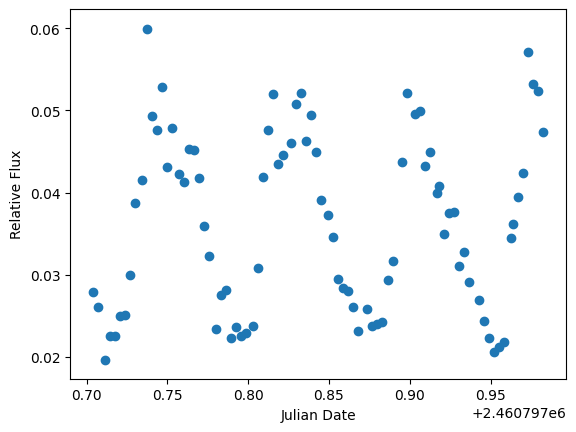

Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: r
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts
Target Name: MR Ser
Target RA: 238.19665374
Target Dec: 18.94134569
Skipping /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//r/maw_MR_Ser_r_120s_2025-05-02T07-02-17.fts due to negative source sum, image should be inspected.
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: r
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts
Target Name: MR Ser
Target RA: 238.19665374
Target Dec: 18.94134569
Skipping /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//r/maw_MR_Ser_r_120s_2025-05-02T06-49-16.fts due to negative source sum, image should be inspected.
Skipping /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//r/maw_MR_Ser_r_120s_2025-

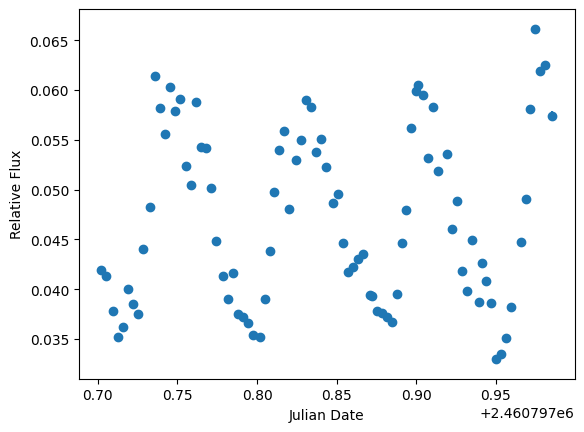

Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: g
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts
Target Name: MR Ser
Target RA: 238.19665374
Target Dec: 18.94134569
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: g
Using reference image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts
Target Name: MR Ser
Target RA: 238.19665374
Target Dec: 18.94134569
Skipping /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//g/maw_MR_Ser_g_120s_2025-05-02T05-11-38.fts due to negative source sum, image should be inspected.
Scale factor is greater than 1.5, check the image: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2//g/maw_MR_Ser_g_120s_2025-05-02T10-02-28.fts
Using directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/
Using filt: g
Using reference 

In [5]:
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

# Select the reference image (IMPORTANT: make sure this is the image that matches the coordinates of the reference stars)
ref_image = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/g/maw_MR_Ser_g_120s_2025-05-02T10-58-54.fts'

# Call the function to do the photometry
for filt in filters:
    perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt)
    calc_ap_ratio(file_dir=file_dir, ref_image=ref_image, filt=filt, larger_ap=18, median=True)
    find_mags(file_dir=file_dir, ref_image=ref_image, filt=filt, save_ref_star_coords=True)

## Here we generate the light curves

### make_light_curve makes the relative flux normalized light curve, optionally with comparison stars

### absolute_light_curve make the magnitude based light curve

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2
Using filters: ['r', 'g']
No i filter data found. Skipping i filter.


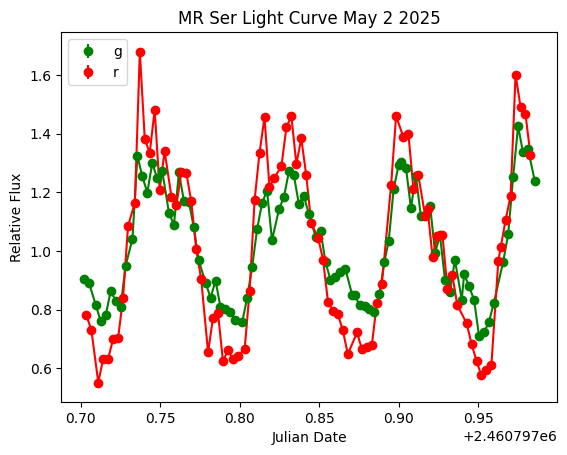

Current working directory: /Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2
Using filters: ['r', 'g']


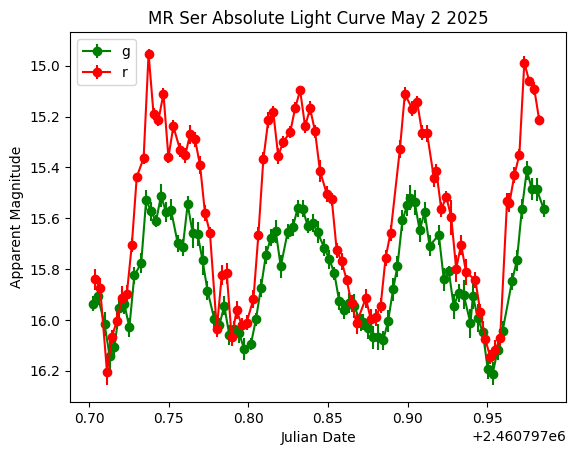

In [6]:
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

make_light_curve(file_dir, filters=filters, title='MR Ser Light Curve May 2 2025', comp_stars=False)
# Call the function to make the absolute light curve
absoulte_light_curve(file_dir, filters=filters, title='MR Ser Absolute Light Curve May 2 2025')


## This section is for plotting the radio data up with the light curve
### Still needs to be tested

In [ ]:
#### THIS SECTION IS FOR ADDING RADIO DATA TO THE LIGHT CURVE
#### HASN'T BEEN TESTED but  SHOULD WORK
#### MAKES ALL PLOTS GO FROM 0 to 1 the flux scale is meaningless
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/'
radio_path = '/Users/nathaliehaurberg/Data/MagneticCVs/MR_Ser_RLMT_May_2/radio.csv'
title = 'MR Ser Light Curve May 3 2025 with Radio Data'

filters = glob.glob(file_dir + '/*/')
filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

for filt in filters:
    results_df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt)
    # normalize for radio
    min_flux = np.min(results_df['target_rel_flux'])
    max_flux = np.max(results_df['target_rel_flux'])
    norm_new_flux = (results_df['target_rel_flux']-min_flux)/(max_flux-min_flux)
    norm_new_flux_err = results_df['target_relerror']/(np.max(results_df['target_rel_flux'])-np.min(results_df['target_rel_flux']))
    results_df['norm_new_flux'] = norm_new_flux
    results_df['norm_new_flux_err'] = norm_new_flux_err
    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_' + filt + '_radio.csv', index=False)

# Add the radio data to the light curve
radio_data = add_radio(path=radio_path, date='2025-05-03')

# Merge the radio data with the light curve data
for filt in filters:
    results_df = pd.read_csv(file_dir + 'Results_' + filt + '_radio.csv')
    results_df = results_df.merge(radio_data, on='Julian_Date', how='left')
    # Save the results to a CSV file
    results_df.to_csv(file_dir + 'Results_' + filt + '_radio.csv', index=False)
    # Plot the light curve with the radio data
    plt.errorbar(results_df['Julian_Date'], results_df['norm_new_flux'], yerr=results_df['norm_new_flux_err'], fmt='o-', label=filt, color="blue", markersize=6)
    plt.errorbar(results_df['Julian_Date'], results_df['norm_x_flux'], yerr=results_df['norm_x_flux_err'], fmt='o-', label='radio', color="red", markersize=6)
    plt.xlabel('Julian Date')
    plt.ylabel('Normalized Flux')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.show()



## This section is for dealing with bouncy or windy data

### This is more complicated but can be done, there are functions for doing so

In [ ]:
# Set the directory containing the image folders and the filt
file_dir = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Apr_13_WRONG_DARKS/'

# filters = glob.glob(file_dir + '/*/')
# filters = [os.path.basename(f.rstrip('/\\')) for f in filters]
filters = ['g', 'r']
# Select the reference image (IMPORTANT: make sure this is the image that matches the coordinates of the reference stars)
ref_image = '/Users/nathaliehaurberg/Data/MagneticCVs/Feb_25_2025_RLMT/VVPup/g/maw_VV_Pup_g_270s_2025-02-25T03-33-35.fts'

# Call the function to do the photometry
results = {}
for filt in filters:
    df = perform_phot(file_dir=file_dir, ref_image=ref_image, filt=filt, display_apertures=False)
    results[filt] = df
    #calc_ap_ratio(file_dir=file_dir, ref_image=ref_image, filt=filt, larger_ap=18, median=True)
    #find_mags(file_dir=file_dir, ref_image=ref_image, filt=filt, save_ref_star_coords=True)

results_e_df = []
file_dir_e = '/Users/nathaliehaurberg/Data/MagneticCVs/VV_Pup_Apr_13_WRONG_DARKS/double/'
# filters = glob.glob(file_dir + '/*/')
# filters = [os.path.basename(f.rstrip('/\\')) for f in filters]

results_e = {}
for filt in filters:
    results_e_df = perform_e_ap_phot(file_dir=file_dir_e, ref_image=ref_image, filt=filt, display_apertures=False)
    results_e[filt] = results_e_df

# Concatenate the results[filt] and results_e[filt] dataframes
for filt in filters:
    results[filt] = pd.concat([results[filt], results_e[filt]], ignore_index=True)
    # Sort by Julian Date
    results[filt] = results[filt].sort_values('Julian_Date')
    # Save the results to a CSV file
    # Recaulculate the normalized flux
    mean_rel_flux, _, _, = sigma_clipped_stats(results[filt]['target_rel_flux'], sigma=  2.0)
    results[filt]['norm_target_rel_flux'] = results[filt]['target_rel_flux']/mean_rel_flux
    results[filt]['norm_target_rel_flux_error'] = results[filt]['target_relerror']/mean_rel_flux
    results[filt].to_csv(file_dir + 'Results_' + filt + '.csv', index=False)